## **표본추출, 데이터 분할, 교차 검증**

### **1)표본추출** 
    1.단순랜덤추출 : 임의의 N개를 추출 
    2.계통추출 : N(30)개의 모집단에서 n(5)개의 샘플을 추출하 기위해서 N/n으로 구간을 나눈다. = K(6) 
    3.집락추출 : 군집별로 랜덤 추출법을 수행 
    4.층화추출: 계층별로 댄덤 추출법을 사용  

```python
1) 단순랜덤 
import pandas as pd
import numpy as np

# 예제 데이터 생성
data = {'ID': np.arange(1, 31)}  # ID 1부터 30까지
df = pd.DataFrame(data)

# 단순 랜덤 추출
random_sample = df.sample(n=5, random_state=42)  # 5개 랜덤 추출
print("단순랜덤추출 결과:\n", random_sample)

2) 계통 추출
def systematic_sampling(df, n):
    step = len(df) // n  # 구간 길이
    systematic_sample = df.iloc[::step]  # step 간격으로 추출
    return systematic_sample

# 예제 데이터 생성
df = pd.DataFrame({'ID': np.arange(1, 31)})

# 5개의 샘플 추출
systematic_sample = systematic_sampling(df, 5)
print("계통추출 결과:\n", systematic_sample)

3) 집락 추출 
# 예제 데이터 생성
data = {'ID': np.arange(1, 31), 'Cluster': np.random.choice(['A', 'B', 'C'], size=30)}
df = pd.DataFrame(data)

# 집락 추출
def cluster_sampling(df, cluster_col, n_clusters):
    clusters = df[cluster_col].unique()  # 군집 리스트
    sampled_clusters = np.random.choice(clusters, n_clusters, replace=False)  # 랜덤으로 n개의 군집 선택
    cluster_sample = df[df[cluster_col].isin(sampled_clusters)]
    return cluster_sample

# 2개의 군집에서 랜덤 추출
cluster_sample = cluster_sampling(df, 'Cluster', 2)
print("집락추출 결과:\n", cluster_sample)

4) 층화 추출 
from sklearn.model_selection import train_test_split

# 예제 데이터 생성
data = {'ID': np.arange(1, 31), 'Strata': np.random.choice(['X', 'Y', 'Z'], size=30)}
df = pd.DataFrame(data)

# 층화 추출
stratified_sample = df.groupby('Strata', group_keys=False).apply(
    lambda x: x.sample(n=2, random_state=42)  # 각 계층에서 2개씩 추출
)
print("층화추출 결과:\n", stratified_sample)



### **교차검증**
데이터의 편중을 막기 위해 별도의 여러 세트로 구성된 학습 데이터와 검증 세트를 구현하여 학습과 평가를 수행
학생 데이터를 다시 분할하여 학습 데이터와 학습된 모델을 일차 평가하는 검증 데이터로 나눔 

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , AdaBoostRegressor
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
import numpy as np 
import pandas as pd

import warnings 
warnings.filterwarnings('ignore')



iris = load_iris()
X = iris.data
target = iris.target 

dt = DecisionTreeClassifier(random_state = 1234)

# 5개의 폴드 세트를 분리하는 K-Fold 객체와 폴드 세트별 정확도 담을 리스트 객체 생성 
kfold = KFold(n_splits = 5)
cv = []
n_iter = 0

for train_index, test_index in kfold.split(X) : 

    x_train, x_test = X[train_index] , X[test_index]
    y_train, y_test = target[train_index] , target[test_index]

    # Model 
    dt.fit(x_train, y_train)
    dt_pred = dt.predict(x_test)
    
    # 반복시 마다 정확도를 측정 
    n_iter += 1
    accuracy = round(accuracy_score(y_test, dt_pred) ,4)
    cv.append(accuracy)

print(cv)


[1.0, 0.9667, 0.8333, 0.9333, 0.8333]


In [11]:
# KFold 2) 
X = iris.data
y = iris.target 

# KFOld 할당 
kf = KFold(n_splits = 5, shuffle = True, random_state = 1243)

# Models 
rf = RandomForestClassifier()
dc = DecisionTreeClassifier()

models = {
    'RandomForest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()}

for name, model in models.items(): 
    cv_score = cross_val_score(model, X, y, cv = kf, scoring = 'neg_mean_squared_error')
    cv = np.mean(cv_score)

# 분할 샘플 교차 검증 성능 
for name, model in models.items() : 
    result = cross_validate(model, X, y, cv = kf, return_train_score = True)
pd.DataFrame(result)

,fit_time,score_time,test_score,train_score
0,0.000363,0.000000,1.000000,1.0
1,0.000000,0.000000,0.933333,1.0
2,0.000000,0.001047,0.866667,1.0
3,0.001132,0.000000,0.900000,1.0
4,0.000000,0.000000,0.966667,1.0


* Stratified K-Fold
  - 불균형한 분포를 가진 레이블 데이터 처리
  - K 폴드가 레이블 데이터 집합이 원본 데이터 집합의 레이블 분포를 학습 및 테스트 세트에 제대로 분배안되는 경우
  - 각 3개의 Label은 50개씩 있는데 K-FOLD로 분할된 데이터 세트가 전체 레이블의 분포를 반영하고 싶을때, 각 클래스별 30개씩 추출해줌

In [12]:
from sklearn.model_selection import StratifiedKFold

iris = load_iris()

iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label']=iris.target
iris_df['label'].value_counts()

# 1) K_Fold 생성
skf = StratifiedKFold(n_splits = 3)
n_iter = 0 

# 2) 
for train_idx, test_idx in skf.split(iris_df, iris_df['label']) : 
    n_iter += 1 
    label_train = iris_df['label'].iloc[train_idx]
    label_test = iris_df['label'].iloc[test_idx]
    print(label_train.value_counts())

label
2    34
0    33
1    33
Name: count, dtype: int64
label
1    34
0    33
2    33
Name: count, dtype: int64
label
0    34
1    33
2    33
Name: count, dtype: int64


In [13]:
X = iris.data
y = iris.target 
# 1) Model
df = DecisionTreeClassifier()
# 2) K-Fold 
skfold = StratifiedKFold(n_splits = 3) 
n_iter = 0 
cv = []

for train_idx , test_idx  in skfold.split(X, y) : 
    x_train, x_test = X[train_idx] , X[test_idx]
    y_train, y_test = y[train_idx] , y[test_idx]

    dt_pred = dt.predict(x_test)

    n_iter += 1 
    accuracy = round(accuracy_score(y_test, dt_pred),4)
    cv.append(accuracy)

print(cv)

[1.0, 0.92, 0.98]


* Cross_val_Score 
 1. 회귀 모델 
    -r2 = 결정계수  
    -neg_mean_absolute_error = 음수로 표현된 평균 절대 오차 (MAE)  
    -neg_mean_squared_error = 음수로 표현된 평균 제곱 오차 (MSE)  
    -neg_root_mean_squared_error = 평균 제곱근 오차 (RMSE)  
    -explained_variance = 설명된 분산 점수   
    -max_error = 최대 절대 오차  

 2. 분류 모델   
    -accuracy = 정확도  
    -precision = 정밀도 (예측된 양성 중 실제 양성인 비율)  
    -recall = 재현율 (실제 양성 중 올바르게 예측한 비율)  
    -f1 = 정밀도 + 재현율의 조화 평균   
    -roc_auc   
    -log_loss = 로그 손실   
    -balanced_accracy  = 클래스 불균형을 고려한 정확도  

In [14]:
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.datasets import load_iris

iris_data = load_iris()
dt_clf = DecisionTreeClassifier(random_state=156)

data = iris_data.data
label = iris_data.target

cross_val_score(dt_clf, data, label , scoring = 'accuracy',cv = 3)

array([0.98, 0.94, 0.98])

** GridSearchCV 
     - 교차 검증을 기반으로, 하이퍼 파라미터의 최적 값을 찾아줌 

In [15]:
from sklearn.model_selection import GridSearchCV , train_test_split

# 1) data_split 
x_train, x_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 123)

dt = DecisionTreeClassifier()

# 2) Parameter = Dictionary 
parameters = {'max_depth' : [1,2,3] ,
              'min_samples_split' : [2,3]}

# 3) GridSearchCV 
# refit = True : 최적의 하이퍼 파라미터를 찾은 뒤 입력한 estimator객체를 해당 하이퍼 파라미터로 재학습 
dt_grid = GridSearchCV(dt, parameters, cv = 3, refit = True)

# 4) Apply to data
dt_grid.fit(x_train, y_train)

# 5) Grid 결과 추출 
score_df = pd.DataFrame(dt_grid.cv_results_)
score_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

#6) Best Param
print(dt_grid.best_params_) 

#7) refit으로 학습된 estimator반환 
estimator = dt_grid.best_estimator_

# 8) GridSearch 의 Best esmitator는 이미 최적의 파라미터로 학습이된 내용 
best_pred = estimator.predict(x_test)
accuracy_score(y_test, best_pred)

{'max_depth': 2, 'min_samples_split': 2}


0.9666666666666667

### 데이터 인코딩 

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

items=['TV','냉장고','전자레인지','컴퓨터','선풍기','선풍기','믹서','믹서']

# 1) LabelEncore선언
en = LabelEncoder()
# 2) fit_transform 
en2 = en.fit_transform(items) 
print(en2)
print(items)

[0 1 4 5 3 3 2 2]
['TV', '냉장고', '전자레인지', '컴퓨터', '선풍기', '선풍기', '믹서', '믹서']


2) 원-핫 인코딩 - OneHotEncoder & get.dummies 

In [17]:
items=['TV','냉장고','전자레인지','컴퓨터','선풍기','선풍기','믹서','믹서']

# 2차원 array 
print(np.array(items).reshape(-1, 1)) 
items = np.array(items).reshape(-1, 1) 

# OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(items) 
onehot_label = onehot.transform(items)
onehot_label.toarray()

[['TV']
 ['냉장고']
 ['전자레인지']
 ['컴퓨터']
 ['선풍기']
 ['선풍기']
 ['믹서']
 ['믹서']]


array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

# 데이터 클래스 불균형 처리

클래스 불균형은 데이터셋에서 특정 클래스의 샘플 수가 다른 클래스에 비해 현저히 적거나 많은 경우를 의미합니다.  
불균형 데이터를 처리하지 않으면 모델이 다수 클래스에 치우쳐 학습될 수 있습니다.  
이를 해결하기 위해 **오버 샘플링**, **언더 샘플링**, **혼합 기법** 등의 방법이 사용됩니다.

## **1. 오버 샘플링 (Oversampling)**
### **정의**
- 소수 클래스의 샘플을 **증가**시켜 클래스 균형을 맞추는 방법.

### **종류**
1. **랜덤 오버 샘플링**  
   소수 클래스의 데이터를 무작위로 복제. 소수의 클래스가 많아지면서 클래스에 대한 가중치가 높아진다. 
2. **SMOTE (Synthetic Minority Over-sampling Technique)**
   임의의 소수 클래스 데이터로부터 인근 소수 클래스 사이에 새로운 데이터를 생성하는 방법
   임의의 소수 클래스 x를 잡고 그로 부터 가까운 K개의 이웃을 찾은 후, k개의 이웃과 x사이에 임의의 새로운 데이터 x를 생성한다.
3. **Borderline SMOTE**
   다수/소수를 구분하는 선을 그을 때 서로 인접해있는 경계선에 있는 소수클래스 데이터에 대해서 SMOTE적용
   소수 클래스 x와 인접하는 데이터를 보고, 소수/다수가 있으면 x를 경계 데이터로 분류하고, 아니면 x는 고려하지 않는다.
4. **K-means SMOTE**
   전체 데이터를 클러스터링 하고, 소수 클래스 샘플이 적게 포함된 군집에 소수 클래스 샘플을 추가하는 방법 
5. **ADASYN (Adaptive Synthetic Sampling)**  
   SMOTE와 유사하지만, 소수 클래스의 경계에 더 많은 데이터를 생성.
6. **SVM SMOTE**
   소수 클래스인 support vector데이터들을 경계데이터로 삼고 SMOTE 실행 
### **적용 방법**
- **SMOTE/ADASYN**: 소수 클래스와 다수 클래스의 **경계 영역**에 대한 학습이 중요할 때.  
- **랜덤 오버 샘플링**: 간단하고 빠르게 균형을 맞추고자 할 때.

### **파이썬 라이브러리**
```python
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, KMeanSMOTE, SVMSMOTE

# 랜덤 오버 샘플링
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X, y)

# SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# ADASYN
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X, y)

kmean = KMeanSMOTE(k_neighbors = 3) 
X_resampled, y_resampled = keman.fit_resample(X, y) 

svm = SVMSMOTE(k_neighbors = 3) 
X_resampled, y_resampled = svm.fit_resample(X, y) 


## **2. 언더 샘플링 (Undersampling)**
### **정의**
- 다수 클래스의 샘플을 **감소**시켜 클래스 균형을 맞추는 방법.

### **종류**
1. **랜덤 언더 샘플링**  
   다수 클래스 데이터를 무작위로 제거.  
2. **Tomek Links**  
   클래스 간 경계에 있는 데이터를 제거하여 샘플 균형을 맞춤.

3. **NearMiss**  
   다수 클래스의 샘플 중 소수 클래스와 가장 가까운 데이터만 선택.

### **적용 방법**
- **랜덤 언더 샘플링**: 샘플 수가 많고, 데이터 손실이 결과에 큰 영향을 주지 않을 때.  
- **Tomek Links/NearMiss**: 클래스 간 경계 학습이 중요할 때.

### **파이썬 라이브러리**
```python
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss

# 랜덤 언더 샘플링
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

# Tomek Links
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X, y)

# NearMiss
nearmiss = NearMiss()
X_resampled, y_resampled = nearmiss.fit_resample(X, y)
```
## **4. 정리**

| **방법**                   | **설명**                                     | **적용 데이터**                                   |
|----------------------------|----------------------------------------------|-------------------------------------------------|
| **랜덤 오버 샘플링**       | 소수 클래스를 무작위 복제                     | 간단하고 데이터 손실이 적은 경우                  |
| **SMOTE**                  | 소수 클래스 데이터를 생성                     | 경계 학습이 중요한 경우                           |
| **ADASYN**                 | 경계에서 소수 클래스를 더 많이 생성             | 경계 학습 강화 및 소수 클래스 다양성 필요 시       |
| **랜덤 언더 샘플링**       | 다수 클래스 데이터를 무작위로 제거             | 데이터가 매우 큰 경우, 일부 데이터 손실 허용 가능  |
| **Tomek Links**            | 클래스 경계 데이터를 제거                     | 클래스 간 경계 학습 강화가 필요한 경우             |
| **NearMiss**               | 소수 클래스와 가까운 다수 클래스를 선택         | 경계 근처 데이터를 학습하는 데 중요한 경우         |
| **SMOTE + Tomek Links**    | 오버샘플링과 언더샘플링 혼합                  | 데이터 크기가 크고, 경계 학습이 중요한 경우        |
| **SMOTE + ENN**            | 오버샘플링 후 노이즈 제거                     | 데이터가 크고 노이즈가 많은 경우                  |



## 데이터 전처리: 대치법 (결측치 처리)
결측치는 데이터 분석 및 모델링 과정에서 흔히 발생하는 문제입니다. 적절한 대치법을 선택하여 결측치를 처리해야 데이터의 품질과 모델 성능을 유지할 수 있습니다.
## **1. 삭제법 (Deletion)**
- 결측값이 있는 행 또는 열을 삭제합니다.
- 결측치가 매우 적고(예: 5% 미만), 데이터의 샘플 수가 충분할 때.
- 결측값이 특정 패턴 없이 무작위로 발생할 때.
#### **단점**
- 데이터가 많이 손실될 가능성이 있음.
- 데이터 샘플이 적을 경우 분석 결과 왜곡 가능.


## **2. 평균 대치 (Mean Imputation)**
- 결측값을 해당 열의 평균값으로 대체합니다.
- 데이터가 정규분포에 가깝고, 이상치가 적을 때.
- 연속형 변수에서 결측값이 적은 경우.
#### **단점**
- 데이터 분산이 감소하여 통계적 추론이 왜곡될 수 있음.
- 이상치에 민감.

## **3. 중앙값 대치 (Median Imputation)**
- 결측값을 해당 열의 중앙값으로 대체합니다.
- 데이터에 이상치(outlier)가 포함된 경우.
- 연속형 변수의 분포가 비대칭적일 때.
#### **장점**
- 이상치의 영향을 줄임.

## **4. 최빈값 대치 (Mode Imputation)**
- 결측값을 해당 열에서 가장 자주 나타나는 값(최빈값)으로 대체합니다.
- 범주형 변수에서 결측값이 있을 때.
#### **단점**
- 변수의 카테고리 분포를 왜곡할 수 있음.

## **5. 단순확률 대치법 (Simple Random Imputation)**
- 결측값을 임의의 다른 샘플에서 무작위로 선택한 값으로 대체합니다.
- 결측치가 무작위로 발생(MCAR: Missing Completely at Random)했다고 가정할 수 있을 때.
- 데이터 분포를 유지하면서 결측값을 처리하고자 할 때.
- Hot-Deck : 현재 진행중인 연구에서 비슷한 성향을 갖는 데이터들 중 랜덤하게 선택, Cold-Deck : 외부에서 비슷한 자료로 대체 
#### **장점**
- 데이터의 분포를 왜곡하지 않음.
- 간단하게 구현 가능.
#### **단점**
- 작은 데이터셋에서는 샘플링 편향이 발생할 수 있음.
- 대체된 값이 실제 데이터를 충분히 반영하지 못할 수 있음.

## **6. K-최근접 이웃 대치법 (K-Nearest Neighbors Imputation)**
- 결측값이 있는 샘플의 K개의 이웃 데이터를 기반으로 값을 대체합니다.
- 데이터의 분포가 복잡하고, 결측값을 근처 데이터로 보완할 수 있을 때.
#### **장점**
- 패턴을 보존할 가능성이 높음.
#### **단점**
- 계산 비용이 높음.
- 많은 결측치가 있을 경우 정확도가 떨어질 수 있음.

## **7. 선형 회귀 대치법 (Regression Imputation)**
- 결측값을 다른 변수와의 선형 관계를 사용하여 예측하고 대체합니다.
- 결측값이 있는 변수와 다른 변수들 간의 상관관계가 높은 경우.
#### **장점**
- 데이터의 상관관계를 유지 가능.
#### **단점**
- 모델 가정을 만족하지 않으면 왜곡 가능.
- 계산 비용이 높음.

## **8. 다중 대치법 (Multiple Imputation)**
- 결측값을 여러 번 대체하여 각 경우에 대해 분석을 수행하고 결과를 결합합니다.
- 데이터 분석의 정밀도가 중요한 경우.
- 결측값이 무작위로 발생했다고 가정할 수 있는 경우.
#### **장점**
- 데이터 손실을 최소화하며, 결과의 신뢰도를 높임.
#### **단점**
- 계산 비용이 매우 높음.

## **9. 시계열 데이터 보간법 (Time Series Interpolation)**
- 결측값을 이전 값, 이후 값 또는 선형 추정값으로 보간합니다.
- 시계열 데이터에서 결측값이 발생했을 때.
- 결측치가 특정 시간에 발생했으며 이전/이후 데이터가 유효할 때.
### **보간 방법**
- 선형 보간 (Linear Interpolation)
- 다항식 보간 (Polynomial Interpolation)
- 이동 평균 (Moving Average)

## **10. 확률적 데이터 대치법 (Stochastic Imputation)**
- 결측값을 해당 열의 평균 또는 예측값으로 대체하되, 대체된 값에 작은 확률적 변동을 추가합니다.
- 데이터의 자연스러운 변동성을 유지하고자 할 때.
- 회귀 분석, 선형 예측 등과 함께 사용 가능.
#### **장점**
- 데이터의 분산을 유지하며, 단순 대치법의 단점을 보완.

## **11. 머신러닝 모델 기반 대치 (Predictive Model Imputation)**
- 머신러닝 알고리즘(예: 랜덤 포레스트, XGBoost 등)을 사용하여 결측값을 예측한 후 대체합니다.
- 데이터의 구조가 복잡하고, 다수의 변수가 상관관계를 가지고 있을 때.
#### **장점**
- 높은 정확도를 보장할 수 있음.
- 비선형 관계를 처리 가능.
#### **단점**
- 계산 비용이 매우 높음.
- 모델링 과정에서 오버피팅 가능성 있음.


## **정리**
| **방법**               | **적합한 데이터**                          | **장점**                               | **단점**                              |
|------------------------|------------------------------------------|---------------------------------------|--------------------------------------|
| 삭제법                 | 결측치가 적고 데이터가 충분할 때            | 간단하고 빠름                          | 데이터 손실 발생                      |
| 평균 대치              | 연속형 변수, 정규분포에 가까운 경우         | 간단하고 빠름                          | 데이터 분산 감소                      |
| 중앙값 대치            | 이상치가 많은 연속형 변수                  | 이상치의 영향을 줄임                    | 분포 왜곡 가능                        |
| 최빈값 대치            | 범주형 변수                               | 간단한 범주형 데이터 처리 가능          | 분포 왜곡 가능                        |
| 단순확률 대치법        | 결측치가 무작위로 발생했다고 가정할 때      | 데이터 분포 유지 가능                  | 샘플링 편향 발생 가능                 |
| K-최근접 이웃 대치법    | 복잡한 데이터, 패턴 보존 필요할 때           | 패턴 보존                              | 계산 비용 높음                        |
| 선형 회귀 대치법       | 상관관계 높은 변수 간 결측치 대치          | 관계 보존 가능                          | 모델 가정 만족 필요, 계산 비용 높음    |
| 다중 대치법            | 데이터 신뢰도가 중요한 경우                | 신뢰도 높음                            | 계산 비용 높음                        |
| 시계열 보간법          | 시계열 데이터                             | 시간적 연속성 유지                     | 복잡한 패턴에 부적합                  |
| 확률적 데이터 대치법    | 데이터의 변동성을 유지하고자 할 때          | 분산 유지 가능                         | 확률 모델 설계 필요                   |
| 머신러닝 기반 대치법    | 데이터의 구조가 복잡하고 상관관계가 클 때    | 높은 정확도, 복잡한 관계 처리 가능       | 계산 비용 높음                        |



In [33]:
# 데이터 전처리 

import numpy as np
wine = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv', index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue']) 

# 1) 평균대치 (Mean Imuputation)
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy = 'mean')

# 2) 중앙값 
imputer2 = SimpleImputer(strategy= 'median')

# 3) 최빈값 
imputer3 = SimpleImputer(strategy = 'most_frequent')

# 4) 단순확률 대치법 
for feat in ['Alcohol','Ash'] : 
    missing_idx = df[df[feat].isna() == True].index 
    df.loc[missing_idx, feat] = df[feat].sample(len(missing_idx)).values

# 5) KNN 
from sklearn.impute import KNNImputer 
imputer4 = KNNImputer(n_neighbors= 5)
df_imputed = imputer4.fit(df)

# 6) 선형 회귀 대치법 
import statsmodels.api as sm

# 선형 회귀 모델 학습
train_data = df.dropna()
model = sm.OLS(train_data['target_column'], train_data[['feature_column']]).fit()

# 결측값 대치
df.loc[df['target_column'].isnull(), 'target_column'] = model.predict(
    df[['feature_column']][df['target_column'].isnull()] )


# 7) 다중 대치법 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
df_imputed = imputer.fit_transform(df)

# 8) 보간법 
# 선형 
df[''] = df['Alcohol'].interpolate(method='linear')
# 다항식 보간
df['Alcohol'] = df['Alcohol'].interpolate(method='polynomial', order=2)


# 9) 확률적 대치
mean = df['Alcohol'].mean()
std_dev = df['Alcohol'].std()
df['Alcohol'] = df['Alcohol'].apply(
    lambda x: np.random.normal(mean, std_dev) if pd.isnull(x) else x)

### 이상치 처리 
    1) ESD : +/- 3 * 표준편차 
    2) 기하평균 +/- 2.5 * 표준편차
    3) IQR 
    4) DBSCAN 군집분석을 사용하여 -1로 분류되는 값을 이상치로 판단

1) 절단 : 이상치들을 제거하는 방법. 이상치가 아니였던 데이터가 삭제 후 이상치가 될 수도 있음 
2) 조정 : 이상치의 상한, 하한선 값으로 보정하는 방법 / 전체 데이터의 소실이 없기 때문에 이상치 조정 전후의 데이터 크기가 동일 
3) 클리핑 : 이상치의 상한값과 하한값을 특정 값으로 지정해 범위를 벗어나는 값을 상한값과 하한값으로 조정하는 방법 (ex 상한 : 5, 하한 1로 지정) 

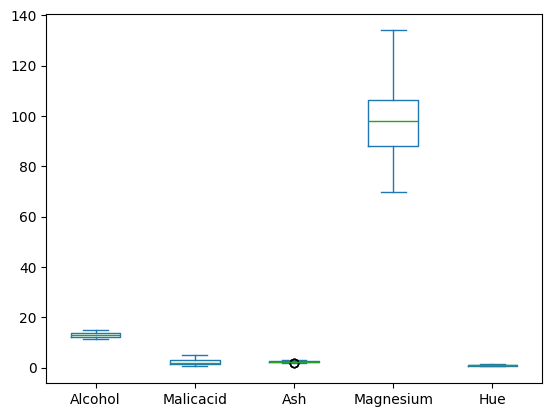

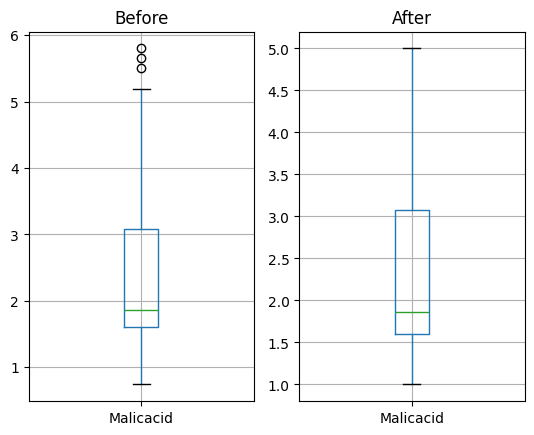

In [48]:
from pandas import read_csv
wine = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv', index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue']) #일부 특징만 사용

# 1) 이상치 iqr 
def outlier_remove(df) : 
    for col in df.columns : 
        iqr = np.quantile(df[col], 0.75) - np.quantile(df[col], 0.25)
        upper = np.quantile(df[col], 0.75) + 1.5 * iqr
        lower = np.quantile(df[col], 0.25) - 1.5 * iqr

        df = df[(df[col] >= lower) &(df[col] < upper)]
    return df

df2 = outlier_remove(wine)
df2.plot(kind = 'box')


# 2) Cliping 
df3 = wine[['Malicacid']].clip(1,5)
fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], df3], axes , ['Before','After']) : 
    data.boxplot(ax=ax)
    ax.set_title(title)
plt.show()

## **1) 표준화 (Standardization) - StandardScaler**

$ Z = \frac{x - \mu}{\sigma} $

**용도:**
- 데이터가 **가우시안(정규) 분포**를 따를 때 유리합니다.
- **서포트 벡터 머신(SVM), 선형 회귀, 로지스틱 회귀** 등의 알고리즘은 대부분 데이터가 정규 분포를 따를 때 성능이 좋아지므로, 표준화가 성능 향상에 도움을 줍니다.
- **중요**: 평균이 0이고 분산이 1로 변환되기 때문에, 변수들 간의 단위 차이를 없애는 효과가 있습니다.

**적용 상황:**
- 데이터가 **정규분포** (혹은 대체로 정규분포)일 때, 예를 들어 테스트 성적이나 신용카드 거래 내역 같은 수치 데이터.
- 값이 **극단적인 이상치**가 없거나 이상치가 모델에 큰 영향을 미치지 않을 때.

---

**2) 정규화 (Normalization) - MinMaxScaler**

$ x' = \frac{x - \min(x)}{\max(x) - \min(x)}$, 결과값은 [0, 1] 범위로 변환됩니다.

**용도:**
- 데이터가 **특정 범위** 내에 있어야 할 때 유용합니다.
- **신경망(Neural Networks)**과 같은 모델에서 활성화 함수가 [0, 1] 범위 내에서 작동하도록 요구될 때 필요합니다.
- **분포가 일정하지 않거나 비대칭적인 데이터**에서 유용합니다.

**적용 상황:**
- **특정 범위**로 제한된 값들이 필요할 때, 예를 들어 이미지 데이터의 픽셀 값(0~255)을 0~1로 정규화하는 경우.
- **이상치**가 있는 경우에는 MinMaxScaler가 민감할 수 있으므로, 이상치가 큰 영향을 미치지 않거나 미리 이상치를 처리한 후 사용하는 것이 좋습니다.

---

**3) Robust Scaling**

$ x' = \frac{x - \text{median}(x)}{\text{IQR}(x)} $, 여기서 IQR(Interquartile Range)은 3사분위수 - 1사분위수입니다.

**용도:**
- **이상치가 많은 데이터**에서 유용합니다. 
- 중앙값과 사분위수를 사용하여 데이터를 변환하므로 **이상치에 영향을 덜 받습니다**.

**적용 상황:**
- **이상치가 많은 경우**, 예를 들어 금융 데이터에서 매우 큰 거래액을 가지는 일부 레코드나, 센서 데이터에서 발생할 수 있는 비정상적 값들을 다룰 때 유용합니다.
- 데이터가 **가우시안 분포를 따르지 않는 경우**에도 잘 동작합니다.
- 예: 주식 가격, 부동산 가격, 센서 데이터(온도, 압력 등)에서 극단적인 이상치가 존재할 때.

---

**4) Quantile Scaling**

**용도:**
- **분포가 매우 비대칭적**이거나 극단적인 이상치가 있을 때, 분포를 0과 1 사이로 압축하여 데이터의 이상치 영향을 최소화합니다.
- 분포가 일정하지 않거나, 값들이 여러 개의 클러스터로 나뉘어 있을 때 유용합니다.
- **백분위수(Quantile)**를 기준으로 재조정하여, 데이터의 특정 분위수에 기반해 값을 재구성합니다.

**적용 상황:**
- **데이터 분포가 매우 비대칭**하거나 **극단적인 이상치가 많을 때**, 예를 들어 분포가 한쪽으로 치우친 데이터셋에 적합합니다.
- **힙 분포**와 같이 데이터가 특정 범위 내에 많이 집중되고, 나머지는 드물게 발생하는 경우(예: 대출 승인 데이터에서 일부 고위험 대출 기록).


In [49]:
from sklearn.preprocessing import RobustScaler , QuantileTransformer

***연습문제

In [50]:
from pandas import read_csv
df = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice1_bank.csv')
print(df.head(3))

   age         job  marital  education default  balance housing loan  \
0   30  unemployed  married    primary      no     1787      no   no   
1   33    services  married  secondary      no     4789     yes  yes   
2   35  management   single   tertiary      no     1350     yes   no   

    contact month   y  
0  cellular   oct  no  
1  cellular   may  no  
2  cellular   apr  no  


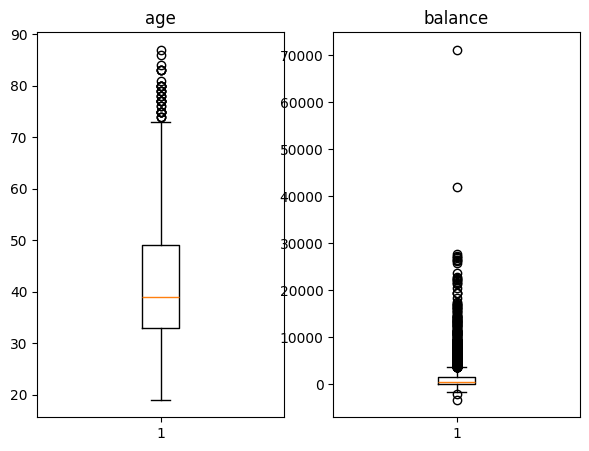

In [51]:
# 2) 전처리 방법 2가지를 설명하고, 각 범주형 변수에 대한 적절한 전처리를 수행 
from matplotlib import pyplot as plt 

num_col = df.select_dtypes(exclude = 'object').columns.tolist()

fig, axes = plt.subplots(1,2, figsize=  (7, 5)) 

for i, ax in enumerate(axes.flat[:]) : 
    col_i = num_col[i]
    ax.boxplot(df[col_i])
    ax.set_title(col_i) 

# Age, Balance 는 이상치 발견, Balance 는 전체 데이터 대비 극단적임으로, 데이터의 소실이 없는 조정을 적용한다.  

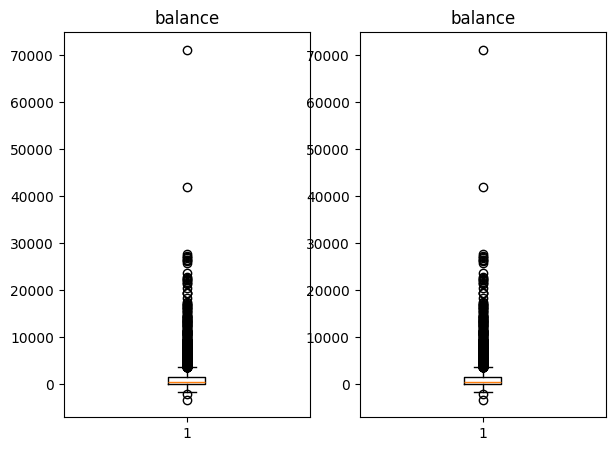

In [52]:
def iqr_remove(df) : 
    #1) choose numetric values 
    num_col = df.select_dtypes(include='number').columns
    
    for col in num_col:  
            iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
            upper = df[col].quantile(0.75) + 1.5 * iqr
            lower = df[col].quantile(0.25) - 1.5 * iqr 
            df = df[(df[col] < upper) & (df[col] > lower)]

    return df.reset_index(drop = True)

# 이상치 제거 df2 
df2 = iqr_remove(df)

fig, axes = plt.subplots(1,2, figsize=  (7, 5)) 
for i, ax in enumerate(axes.flat[:]) : 
    col_i in ['age','balance']
    ax.boxplot(df[col_i])
    ax.set_title(col_i) 

In [53]:
# 범주형 변수를 전처리 하는 방법 : 원핫 인코딩, 더미코딩, 레이블 인코딩 
# 더미코딩 : 변수가 N개 일떄 가변수 n-1 개를 생성함으로써 다중 공선성을 방지하는 변수변환 
# 레이블 인코딩은 : 문자열인 수준을 숫자로 매핑하는 것 

df3 = df2.copy()
#이진 변수, 서열 척도 : 레이블 인코딩 범주형 변수는 더미 코딩을 진행

for col in df3.columns : 
    if col in ['default' ,'housing' ,'loan' ,'y'] : 
        df3[col] = df3[col].map({'yes':1 , 'no' : 0 })
        
    elif col == 'education' : 
        df3[col] = df3[col].map({'primary':1, 'secondary':2, 'tertiary':3, 'unknown':0})
        
    elif col in ['marital','job','contact','month'] : 
        dummies = pd.get_dummies(df3[col], prefix = col, dtype = float)
        df3 = pd.concat([df3.drop(columns = [col]) , dummies], axis = 1)

df3.head()


,age,education,default,balance,housing,loan,y,job_admin.,job_blue-collar,job_entrepreneur,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,30,1,0,1787,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,35,3,0,1350,1,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,3,0,1476,1,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,59,2,0,0,1,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,35,3,0,747,0,0,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# 문제 3) 수치형 변수를 처리하는 방법 2가지  
# 수치형 변수는 age와 balance 인데, 단위가 다르다. 
# 모델을 학습할때 값의 범위가 큰 특성이나, 특성 간의 척도가 다를 경우 회귀계수가 왜곡되거나, 학습이 제대로 이루어지지 않기 때문에 
# 일반적으로 feature scaling 에 사용되는 방법으로 표준화(standardization)과 min_max_scaling 이 사용된다.
# 표준화의 경우, 각 특성들을 0에 가까운 평균을 가지게 되며, 대등하게 비교할 수 있는 스케일을 가지게 된다. 
# 하지만, 여전히 이상치의 영향을 받으며 최소값과 최대값의 크기를 제한하지 않기 때문에 특성의 범위가 여전히 클수 있다
# Min_Max_Scaling (최대-최소 스케일링)은 모든 특성이 0과 1에 위치하로독 데이터를 변경하기 때문에, 데이터의 픽셀값과 같이 
# 처음부터 범위가 정해진 변수는 최대-최소 스케일링을 사용한다. 변환 후 평균이 정확히 0이 되지 않고, 이상치의 영향을 받기 쉬운 단점이 있다. 

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled =  ss.fit_transform(df3[['age','balance']])
df3[['age','balance']] = scaled


In [55]:
# 문제 4) 클래스 불균형이 있는지 확인하고, 그렇게 생각한 이유를 작성하시오. 
t = pd.DataFrame(df3['y'].value_counts())
t['%'] = df3['y'].value_counts(normalize = True)
t

# 문제 5) 불균형 해소 방법 
# 오버, 언더 샘플링이 있는데, 데이터 크기가 비교적 작은 경우에는 오버 샘플링을 진행 
# OverSmapling 에는 랜덤오버, SMOTE, BorderLIne, SVM, K-mean SMOTE 등이 있다. 
# 랜덤 오버 샘플링은 기존의 소수 클래스를 단순 복제하여 클래스의 불균형 비율을 맞추는 방법이다. 
# 분포의 변화는 없으나, 소수 클래스의 숫자가 늘어나기 때문에 더 많은 가중치를 받게 되어 유효하다고 본다. 하지만 과적합의 위험이 있다. 

from imblearn.over_sampling import RandomOverSampler, SVMSMOTE
X = df3.drop('y', axis=1)
y = df3[['y']]
os = SVMSMOTE()
balX, baly = os.fit_resample(X, y)
print('랜덤오버샘플링 결과')
print(baly.value_counts(), "\n")

랜덤오버샘플링 결과
y
0    3546
1    3546
Name: count, dtype: int64 



  File "C:\Users\i2max-DoeunKim\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [56]:
## 연습 2) 타이타닉 
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/algoboni/refs/heads/main/1-1_titanic.csv')
df.isna().sum()

# 1) 결측처리 
df['Age'].fillna(df['Age'].mean(),inplace=True)
df['Cabin'].fillna('N',inplace=True)
df['Embarked'].fillna('N',inplace=True)

In [57]:
# 2) Cabin 처리 
df['Cabin'] = df['Cabin'].str[:1]

<Axes: xlabel='Age_cat', ylabel='Survived'>

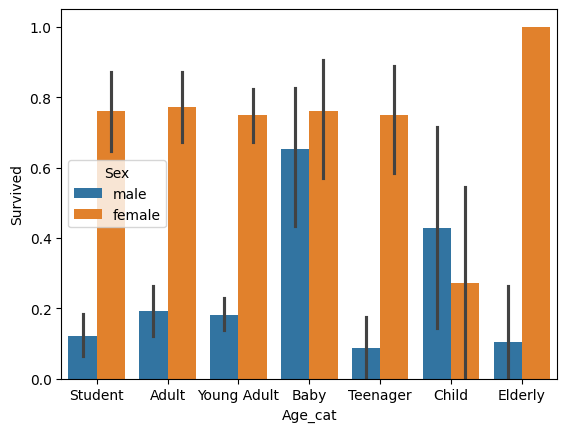

In [58]:
# 3) Age 구간 변수화 
import seaborn as sns
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat 

df2 = df.copy()
df2['Age_cat'] = df2['Age'].apply(lambda x : get_category(x))

sns.barplot(x ='Age_cat' , y = 'Survived' , hue = 'Sex', data = df2)

In [59]:
from sklearn.preprocessing import LabelEncoder

for col in df.columns : 
    en = LabelEncoder()
    if col in ['Sex', 'Cabin', 'Embarked'] : 
        df2[col] = en.fit_transform(df2[col]) 

In [60]:

df = pd.read_csv('https://raw.githubusercontent.com/doeungim/algoboni/refs/heads/main/1-1_titanic.csv')

def fillna(df) : 
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace =True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0 , inplace = True)
    return df

## remove cols 
def remove_cols(df) : 
    df.drop(columns = ['Name', 'Ticket', 'PassengerId'], axis = 1, inplace = True)
    return df


def label_encoding(df) : 
    df['Cabin'] = df['Cabin'].str[:1]
    cols =  ['Sex', 'Cabin', 'Embarked'] 
    for col in cols : 
        la = LabelEncoder()
        df[col] = la.fit_transform(df[col])
    return df 


# 전처리 함수 오출
def transform_features(df) : 
    df = fillna(df)
    df = remove_cols(df)
    df = label_encoding(df)
    return df 

df2 = transform_features(df)

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

X = df.drop(columns = 'Survived')
y =df['Survived']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=11)

models = {
'dt_clf' : DecisionTreeClassifier(random_state=11),
'rf_clf' : RandomForestClassifier(random_state=11),
'lr_clf' : LogisticRegression(solver='liblinear') }

res = []
for name, model in models.items() : 
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    res.append([name, accuracy])
    
pd.DataFrame(res)


,0,1
0,dt_clf,0.787709
1,rf_clf,0.854749
2,lr_clf,0.865922


In [62]:
# 여러 머신 러닝 모델의 교차 검증을 통해 평균 정확도를 검증 - 랜덤포레스트가 가장 높음 
res2 = []
kf = KFold(n_splits = 5, shuffle = True, random_state = 1243)
for name, model in models.items() : 
    cv_score = cross_val_score(model, X, y, cv = kf, scoring = 'accuracy')
    res2.append([name, cv_score.mean()])

pd.DataFrame(res2, columns = ['Model','Mean Accuracy'])

,Model,Mean Accuracy
0,dt_clf,0.772161
1,rf_clf,0.809259
2,lr_clf,0.793522


In [63]:
# 1) 모델 설정 
models = {
'dt_clf' : DecisionTreeClassifier(random_state=11),
'rf_clf' : RandomForestClassifier(random_state=11),
'lr_clf' : LogisticRegression(solver='liblinear') }

# 2) 분할 
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=11) 

# 3) K-Fold 설정 
res3 = []
kfold = KFold(n_splits=5, shuffle = True, random_state = 2345)

for name, model in models.items() : 
    # 교차 검정을 통한 평균 정확도 계산 
    cv_score = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    mean_accuracy = cv_score.mean()

    # 모델 학습및 테스트 평가 
    model.fit(X_train, y_train)
    test_accuracy = accuracy_score(y_test, model.predict(X_test)) 

    res3.append([name, mean_accuracy, test_accuracy])

pd.DataFrame(res3, columns=['Model', 'Mean Cross-Validation Accuracy', 'Test Accuracy'])

,Model,Mean Cross-Validation Accuracy,Test Accuracy
0,dt_clf,0.752822,0.787709
1,rf_clf,0.810421,0.854749
2,lr_clf,0.778125,0.865922


In [64]:
# 가장 높은 모델의 하이퍼 파라미터 설정 

rf_clf = RandomForestClassifier(random_state=11)

parameters = {
    'max_depth': [2,3,5,10] ,
    'min_samples_split' : [2,3,4],
    'min_samples_leaf': [2,3,5]   
}

rf_grid = GridSearchCV(rf_clf, parameters, scoring = 'accuracy', cv = 5)
rf_grid.fit(X_train, y_train)
rf_pred = rf_grid.predict(X_test)

print(rf_grid.best_params_)  #최척의 파라미터 
print(rf_grid.best_score_)  # 정확도


# 하이퍼 파라미터를 넣은 최고의 모델은 rf_grid.best_estimator_ 
best_model = rf_grid.best_estimator_ 

# best 모델로 예측 
best_pred = best_model.predict(X_test)
print(accuracy_score(y_test, best_pred))

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.8174431202600216
0.8770949720670391
